## Process
1. Scoping : 문제정의
2. Data : 데이터 수집, 분석
3. Modeling : 적합한 모델 선정
4. Training : 데이터 학습
5. Analysis : 모델 분석 및 평가

## 1. Scoping (문제 정의)

- Garbage Image가 주어졌을 때 해당 Image가 어떤 Garbage인지를 분류합니다.
  - Input : Image File
  - Output : Garbage Class

## 2. Data (데이터 수집 및 분석)
- 데이터 수집은 최초 한번으로 끝나는 것이 아닌 이후 모델링, 학습, 평가 기간동안 계속해서 염두해야 합니다.
- 데이터 분석은 정량적, 정성적으로 살펴보아야 합니다.

### 2.1. Summary

- Dataset Download : https://www.kaggle.com/datasets/vivmankar/asian-vs-african-elephant-image-classification
- Dataset Tree
    ```
        elephants
        ├─train
        │  ├─African : 389 files
        │  └─Asian   : 388 files
        └─test(val)
           ├─pizza     : 389 files
           └─icecream  : 388 files
    ```
- Dataset Configuration
    - The number of images : 1,554 files
    - The number of classes : 2
        - pizza, icecream
    - Average number of images per class : 777 files

### 2.2. Data Analysis

실제 데이터에 어떤 이미지가 있는지 살펴봅니다.

(Optional) gdrive에 있는 데이터를 mount 할때 아래와 같이 mount 후 데이터 경로를 지정해줍니다.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
dir_main = "/content/drive/MyDrive/데이터분석/딥러닝&인공지능/컴퓨터 비전 실습/실습/Classfication/elephant_image"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


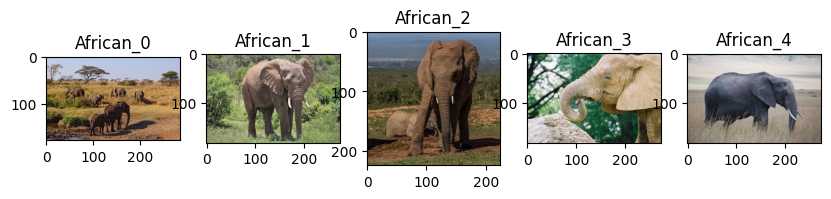

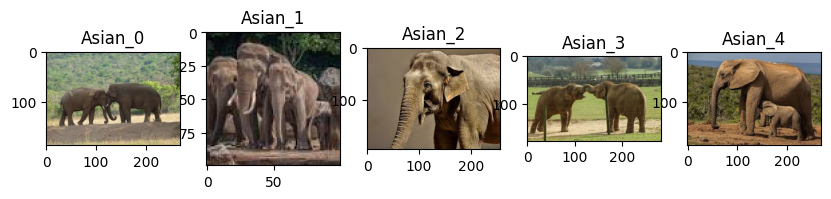

In [ ]:
import os
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image

dir_main = "/content/drive/MyDrive/데이터분석/딥러닝&인공지능/컴퓨터 비전 실습/실습/Classfication/elephant_image"
classes = ['African', 'Asian']
source = "train"
image_paths = glob(os.path.join(dir_main, source, "*/*.jpg"))

cls_image_paths = {}
n_show = 5
for cls in classes:
    cls_image_paths[cls] = [image_path for image_path in image_paths if cls == image_path.split("/")[-2]][:n_show]

for cls in classes:
    fig, axes = plt.subplots(nrows=1, ncols=n_show, figsize=(10,2))
    for idx, image_path in enumerate(cls_image_paths[cls]):
        img = Image.open(image_path)
        axes[idx].set_title(f"{cls}_{idx}")
        axes[idx].imshow(img)

### 2.3. Preprocessing dataset for train, validation and test

#### Preprare the dataset

In [ ]:
import os
import numpy as np
from glob import glob
np.random.seed(724)

#해당 데이터셋은 train과 test 폴더로 이미 데이터가 구분되어 있음
dir_main = "/content/drive/MyDrive/데이터분석/딥러닝&인공지능/컴퓨터 비전 실습/실습/Classfication/elephant_image"
classes = ['African', 'Asian']

dir_train = os.path.join(dir_main, 'train')
x_train = glob(f"{dir_train}/*/*.jpg")
y_train = np.array([x.split("/")[-2] for x in x_train])

dir_test = os.path.join(dir_main, 'test')
x_test = glob(f"{dir_train}/*/*.jpg")
y_test = np.array([x.split("/")[-2] for x in x_test])

dir_val = os.path.join(dir_main, 'test')
x_val = glob(f"{dir_train}/*/*.jpg")
y_val = np.array([x.split("/")[-2] for x in x_val])


In [ ]:
def get_numbers(ys, cls=None):
    cls_cnt = {}
    for y in ys:
        if y not in cls_cnt.keys():
            cls_cnt[y]=0
        cls_cnt[y]+=1
    if cls is None:
        return cls_cnt
    return cls_cnt[cls]

print(f"Class\t\tTrain\tVal\tTest\n")
for cls in classes:
    print(f"{cls:10}\t{get_numbers(y_train, cls)}\t{get_numbers(y_val, cls)}\t{get_numbers(y_test, cls)}")

Class		Train	Val	Test

African   	389	389	389
Asian     	388	388	388


### 2.4. Create DataLoader

In [ ]:
import torch
from torch.utils.data import Dataset
from glob import glob

#class를 정의할 때 서로 다른 인스턴스를 결합하기 때문에, self 필요?

#어떤 경로에서, 어떤 이미지를, 어떤 파일 리스트를 가져올지 결정
class ElaphantDataset(Dataset):
    def __init__(self, dir_dataset, tr):
        self.dir_dataset = os.path.abspath(dir_dataset)
        self.filelist = glob(self.dir_dataset + '/*/*.jpg')
        assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
        self.classes = ['African', 'Asian']
        #self.classes = {'African':0, 'Asian':1}
        self.tr = tr

    def get_image(self, filename):
        img = Image.open(filename)

        #이미지의 회전 방향 정보와 같은 메타정보를 가져오기 위해 getexif 활용
         #이후 0x0112라는 회전정보를 사용하는 태그키를 사용해서 찾음
        exif = img.getexif()
        orientation = exif.get(0x0112)
        transpose_method = {
            2: Image.Transpose.FLIP_LEFT_RIGHT,
            3: Image.Transpose.ROTATE_270,
            4: Image.Transpose.FLIP_TOP_BOTTOM,
            5: Image.Transpose.TRANSPOSE,
            6: Image.Transpose.ROTATE_270,
            7: Image.Transpose.TRANSVERSE,
            8: Image.Transpose.ROTATE_90
        }.get(orientation)
        if transpose_method is not None:
            img = img.transpose(transpose_method)
        img = self.tr(img)
        return img

    def get_label(self, filename):
        label = np.array([0] * len(self.classes))
        cls = filename.split('/')[-2]
        #binary classification을 하려면
         #밑에 두 줄 지우고
         #return self.classes[cls].type(torch.FloatTensor) 입력
        label[self.classes.index(cls)] = 1
        return torch.from_numpy(label).type(torch.cuda.FloatTensor)


    def __getitem__(self, idx):
        filename = self.filelist[idx]
        img = self.get_image(filename)
        label = self.get_label(filename)
        return img, label

    def __len__(self):
        return len(self.filelist)


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    #instance의 데이터가 list나 tuple일 경우 각 요소를 device로 이동
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    #GPU냐 CPU냐에 따라 매핑
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [ ]:
# import torch
# from torch.utils.data import Dataset
# from glob import glob

# class PizzaIcecreamDataset(Dataset):
#     def __init__(self, dir_dataset, tr):
#         self.dir_dataset = os.path.abspath(dir_dataset)
#         self.filelist = glob(self.dir_dataset + '/*/*.jpg')
#         assert len(self.filelist)!=0, f"{self.dir_dataset + '/*/*.jpg'} is empty"
#         self.classes = ['African', 'Asian']
#         self.tr = tr

#     def get_image(self, filename):
#         img = Image.open(filename)
#         img = self.tr(img)
#         return img

#     def get_label(self, filename):
#         label = np.array([0] * len(self.classes))
#         cls = filename.split('/')[-2]
#         label[self.classes.index(cls)] = 1
#         return torch.from_numpy(label).type(torch.FloatTensor)


#     def __getitem__(self, idx):
#         filename = self.filelist[idx]
#         img = self.get_image(filename)
#         label = self.get_label(filename)
#         return img, label

#     def __len__(self):
#         return len(self.filelist)


# def get_default_device():
#     """Pick GPU if available, else CPU"""
#     if torch.cuda.is_available():
#         return torch.device('cuda')
#     else:
#         return torch.device('cpu')

# def to_device(data, device):
#     """Move tensor(s) to chosen device"""
#     if isinstance(data, (list, tuple)):
#         return [to_device(x, device) for x in data]
#     return data.to(device, non_blocking=True)

# class DeviceDataLoader():
#     """Wrap a dataloader to move data to a device"""
#     def __init__(self, dl, device):
#         self.dl = dl
#         self.device = device

#     def __iter__(self):
#         """Yield a batch of data after moving it to device"""
#         for b in self.dl:
#             yield to_device(b, self.device)

#     def __len__(self):
#         """Number of batches"""
#         return len(self.dl)


In [ ]:
from torch.utils.data import DataLoader
import torchvision.transforms as T

# print(model.default_cfg['mean']) # 'mean': (0.5, 0.5, 0.5)
# print(model.default_cfg['std']) # 'std': (0.5, 0.5, 0.5)

#imageNet 데이터셋의 평균과 표준편차 사용
normalize = T.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

# normalize = T.Normalize(
#     mean=[0.5, 0.5, 0.5],
#     std=[0.5, 0.5, 0.5]
# )

#정규화된 이미지를 이미지 형태로 다시 돌림
normalize_inverted = T.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

#채널이 1개인 값이 있을 경우 채널을 3개로 늘리는 방법
channel1to3 = T.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0)==1 else x)
#채널이 3개인 값을 1개로 줄이는 방법
channel3to1 = T.Grayscale(num_output_channels=1)

#데이터증강 및 정규화
train_tr = T.Compose([
    T.Resize((256, 256)),
    T.RandomCrop(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    channel1to3,
    normalize
])

#테스트 데이터는 일반적인 데이터 크기인 224로 맞춤
test_tr = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    channel1to3,
    normalize
])

#데이터셋과 데이터로더를 따로 설정
 # 코드의 모듈화를 위함
train_ds = ElaphantDataset(os.path.join(dir_main, "train"), train_tr)
val_ds = ElaphantDataset(os.path.join(dir_main, "test"), test_tr)
test_ds = ElaphantDataset(os.path.join(dir_main, "test"), test_tr)

#데이터 셋을 배치 단위로 묶어서 데이터로더로 만듦
batch_size = 64
train_dl = DataLoader(train_ds, shuffle=True, num_workers=0, batch_size=batch_size)
val_dl = DataLoader(val_ds, shuffle=True, num_workers=0, batch_size=batch_size)
test_dl = DataLoader(test_ds, shuffle=True, num_workers=0, batch_size=batch_size)

device = get_default_device()
#device = torch.device('cuda')

train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### 3. Modeling

#### 3.1. Select Model - Vision Transformer

MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer ([Paper](https://arxiv.org/abs/2110.02178)) 이란?
MobileViT (Mobile Vision Transformer)은 경량화된 모바일 기기에서도 효율적으로 실행 가능한 Vision Transformer 기반의 이미지 분류 모델입니다.

MobileViT의 전신이 되는 Vision Transformer의 특징을 먼저 살펴보도록 하겠습니다.

<center><img src = "https://drive.google.com/uc?id=1Ir6hm-UtAuKWuyyrHu86CA2iQ_cUwGkD"  height = 300> </center>

1. Vision Transformer는 이미지 분류에 대한 전통적인 CNN 기반 모델 대신 **self-attention mechanism을 사용**하는 새로운 딥러닝 모델입니다. 이 모델은 이전에 자연어 처리에서 널리 사용되어 온 transformer 구조를 영상 처리에 적용한 것입니다. 이 모델의 특징은 다음과 같습니다:

2. Self-attention mechanism : Vision Transformer 모델은 각 이미지 패치를 처리하기 위해 self-attention mechanism을 사용합니다. 이는 입력 이미지를 작은 패치로 분할하고, 이러한 패치를 입력으로 사용하여 transformer encoder에서 self-attention을 수행합니다. 이렇게 함으로써 이미지의 각 패치가 서로 다른 패치와 어떻게 상호 작용하는지에 대한 정보를 효과적으로 모델링할 수 있습니다.

3. 이미지 분할 : Vision Transformer 모델은 입력 이미지를 작은 패치로 분할합니다. 이를 통해 모델은 전체 이미지를 한 번에 처리하는 대신, 각 패치를 독립적으로 처리할 수 있습니다. 이러한 방식은 모델의 계산 복잡도를 줄이면서도 이미지의 전체적인 구조를 보존할 수 있습니다. 또한, 이 모델은 다른 모델 아키텍처와 함께 사용될 수 있으며, 효과적인 전이 학습을 통해 다른 분야에서 사용될 수 있습니다.

4. 모듈러 구조 : Vision Transformer 모델은 transformer encoder와 MLP (Multi-Layer Perceptron) decoder로 구성됩니다. 이 모듈러 구조를 사용하여, 모델을 더 쉽게 수정하고 조정할 수 있습니다.

<center><img src = "https://drive.google.com/uc?id=14bTmSsBBwI_cpJUgm6FWHrqb7wH5yaP0"  height = 300> </center>

MobileViT는 ViT(Vision Transformer)와의 차이를 통해 좀더 살펴보겠습니다. 우선 두 모델 모두 Transformer 아키텍처를 기반으로 한 딥러닝 모델입니다. 하지만 MobileViT은 모바일 기기에서도 빠르고 경량화된 실행이 가능하도록 최적화된 구조를 가지고 있습니다. 이에 비해 ViT는 컴퓨팅 리소스가 더 많은 환경에서 높은 성능을 발휘합니다.

그런데 이 같이 큰 파라미터는 적은 양의 데이터로 학습시 오버피팅되기 쉽기 때문에, 상대적으로 데이터 증진과 정규화에 민감할 수 밖에 없습니다. 그래서 이를 해결하기 위해 MobileVit에서 제안된 MobileViTBLock을 통해 적은 수의 파라미터로 local과 global information을 modeling하여 적은 양의 데이터 대비 좋은 성능을 내어 경량화, 범용성, 낮은 지연 시간의 특징을 갖고 있다.


1. MobileViT Block: MobileViT은 ViT에서 사용되는 큰 어텐션 헤드를 작은 어텐션 헤드로 대체하여 모델의 크기를 줄이고, Depthwise Separable Convolution과 Pointwise Convolution 등의 경량화된 레이어를 사용하여 모바일 기기에서도 빠른 실행이 가능하도록 최적화된 구조를 가지고 있습니다.


 - local representation: local spacial information은 n*n convolution을 이용해 획득하고 point-wise convolution을 이용해 인풋텐서채널의 선형 조합으로 고차원 정보 생성
    <center><img src = "https://drive.google.com/uc?id=1zEwazHYt1L1HELemzTx9f9uwPtUpJur8"  height = 300> </center>

 - Depthwise Separable Convolution Block: 이 블록은 입력 데이터를 Depthwise Separable Convolution(깊이별 분리 합성곱)을 통해 처리합니다. Depthwise Separable Convolution은 컨볼루션 연산을 Depthwise Convolution(깊이별 합성곱)과 Pointwise Convolution(점별 합성곱)으로 분리하여 연산량을 크게 줄일 수 있는 방법입니다. 이를 통해 모델의 크기와 실행 속도를 줄일 수 있습니다.

- Self-Attention Block: 이 블록은 입력 데이터에 Self-Attention 메커니즘을 적용합니다. Self-Attention은 입력 시퀀스에서 각 요소들 간의 상호작용을 고려하여 정보를 추출하는 메커니즘입니다. 이를 통해 입력 데이터의 중요한 부분에 집중하고, 불필요한 정보를 제거하여 모델의 성능을 개선할 수 있습니다.


2. 성능: MobileViT는 ViT와 비교하여 모델의 크기가 작고, 경량화된 구조를 가지기 때문에 더 적은 컴퓨팅 리소스를 사용하여 실행할 수 있습니다. 이에 따라 모바일 기기에서도 높은 성능을 발휘할 수 있습니다. 하지만 ViT는 모델의 크기가 크고, 보다 복잡한 구조를 가지기 때문에 더 높은 성능을 보입니다. 따라서, MobileViT는 모바일 기기에서 경량화된 실행이 가능하도록 최적화된 모델이며, ViT는 더 큰 컴퓨팅 리소스에서 높은 성능을 발휘할 수 있는 모델입니다.

3. 다양한 데이터셋에서 우수한 성능: MobileViT은 다양한 이미지 분류 데이터셋에서 우수한 성능을 보입니다. 예를 들어, ImageNet 데이터셋에서 MobileViT-Slim은 Top-1 정확도 77.1%, MobileViT-Lite는 Top-1 정확도 73.6%를 달성하였습니다. 이는 경량화된 모델임에도 불구하고, 대부분의 모델 크기가 큰 Vision Transformer 모델들보다 높은 성능을 보인다는 것을 의미합니다.


#### 3.2. Package Installation

아래 package를 설치 합니다.
- [timm](https://github.com/rwightman/pytorch-image-models), [opencv](https://github.com/opencv/opencv-python), [sklearn](https://scikit-learn.org/stable/index.html)

```
    # install dependancy
    pip install timm
    pip install opencv-python
    pip install scikit-learn
    # pip install -r requirements.txt
```

#### 3.3. Loading Model

Timm에는 기존에 학습된 여러 pretrained 모델을 제공합니다.

In [ ]:
!pip install timm

In [ ]:
!pip install opencv-python

In [ ]:
!pip install scikit-learn

In [ ]:
!pip install -r requirements.txt

In [ ]:
import timm

#tim에서 mobilevitv와 관련된 모델 가져옴
 # 숫자가 낮을 수록 경량화되어 있지만 성능은 떨어진다고 생각하면 됨

print(f"The number of pretrained models : {len(timm.list_models('*', pretrained=True))}")
timm.list_models('mobilevitv*', pretrained=True)

The number of pretrained models : 1260


['mobilevitv2_050.cvnets_in1k',
 'mobilevitv2_075.cvnets_in1k',
 'mobilevitv2_100.cvnets_in1k',
 'mobilevitv2_125.cvnets_in1k',
 'mobilevitv2_150.cvnets_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k',
 'mobilevitv2_150.cvnets_in22k_ft_in1k_384',
 'mobilevitv2_175.cvnets_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k',
 'mobilevitv2_175.cvnets_in22k_ft_in1k_384',
 'mobilevitv2_200.cvnets_in1k',
 'mobilevitv2_200.cvnets_in22k_ft_in1k',
 'mobilevitv2_200.cvnets_in22k_ft_in1k_384']

In [ ]:
# model = timm.create_model('mobilevitv2_100', pretrained=True)
# model.to(device)
# model.default_cfg

In [ ]:
import timm
import torch.nn.functional as F
import torch.nn as nn

#보통 mobilevitv2_100을 사용함
class MobileViT(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = timm.create_model('mobilevitv2_100', pretrained=True, num_classes=len(classes))

    def forward(self, x):
        return torch.sigmoid(self.model(x))

#여기서 다시 모델을 가져왔기 때문에 model.to(device)로 밑에서 다시 해야 함
model = MobileViT()
model.eval()
model(torch.randn(1, 3, 224, 224)).shape
# to_device(model, device)

torch.Size([1, 2])

In [ ]:
import pickle
import os

class TrainHelper():
    def __init__(self, save_path='./ckpt/history.pickle', history=[]):
        self.history = history
        self.save_path = save_path
        os.makedirs(os.path.dirname(save_path), exist_ok=True)

    #다중 분류에서 가장 큰 값을 모델이 선택하기 때문에 max값을 pred로 가져옴
    def accuracy(self, outputs, labels):
        pred = torch.max(outputs, dim=1)[1]
        gt = torch.max(labels, dim=1)[1]
        return torch.tensor(torch.sum(pred == gt).item() / len(pred))

    #validation과 evaltution은 기울기를 계산할 필요가 없기 때문에 no_grad()
     #즉, backpropagation 이 필요 없기 때문에
    @torch.no_grad()
    def validation(self, batch):
        images, labels = batch
        out = model(images)
        acc = self.accuracy(out, labels)
        loss = F.binary_cross_entropy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    @torch.no_grad()
    def evaluation(self, model, data_loader):
        model.eval()
        outputs = [self.validation(batch) for batch in data_loader]
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': round(epoch_loss.item(), 5), 'val_acc': round(epoch_acc.item(), 5)}

    def logging(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        self.history.append(result)
        with open(self.save_path, 'wb') as f:
            pickle.dump(self.history, f)

train_helper = TrainHelper()

In [ ]:
model = model.to(device)
train_helper.evaluation(model, val_dl)

{'val_loss': 0.69364, 'val_acc': 0.49946}

## 4.Training

In [ ]:
#반복문의 진행 상황을 텍스트로 출력
from tqdm import tqdm

#GPU RAM이 부족해서 에폭 2로 지정..
epochs = 3
#최적화 알고리즘으로 Adam 사용해서 Bias 보정
optimizer = torch.optim.Adam(model.parameters(), lr=5.5e-5)

#가장 높은 검증 정확도를 추정하기 위해 활용
val_acc_best = 0

#모델의 가중치 및 매개변수를 특정 시점에서 저장하는 데 사용
 #os.makedirs를 통해 디렉토리 생성 및 exist_ok
save_model_path = "./ckpt/"
os.makedirs(save_model_path, exist_ok=True)
for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    for batch in tqdm(train_dl):
        inputs, targets = batch
        outputs = model(inputs)
        loss = F.binary_cross_entropy(outputs, targets)

        train_losses.append(loss)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Validation phase
     #train_losses를 하나의 텐서로 쌓아줌 (통합)
      #이후 평균값을 계산하여 평균 손실을 얻음
       #item 함수를 통해 python 숫자로 변환
    result = train_helper.evaluation(model, val_dl)
    result['train_loss'] = torch.stack(train_losses).mean().item()

    # Save the best model
     #변수가 locals에 존재하고 해당 경로에 모델 파일이 미지 존재하면 os.remove()
      #중복으로 모델 파일이 저장되는 것을 방지하기 위함
     #모델이 최고 성능을 보일 때 모델의 상태도 저장 (최상의 상태 추적을 위함)
    if result['val_acc'] >= val_acc_best:
        val_acc_best = result['val_acc']
        if 'save_model_name' in locals() and os.path.exists(save_model_name):
            os.remove(save_model_name)
        save_model_name = os.path.join(save_model_path, f"best_ep_{epoch}_{val_acc_best}.pt")
        torch.save(model.state_dict(), save_model_name)
        print(f"Saved PyTorch Model State to {save_model_name}")

    train_helper.logging(epoch, result)

# Save the last model
save_model_name = os.path.join(save_model_path, f"last_ep_{epoch}_{val_acc_best}.pt")
torch.save(model.state_dict(), save_model_name)

##### Train & Validation Losses

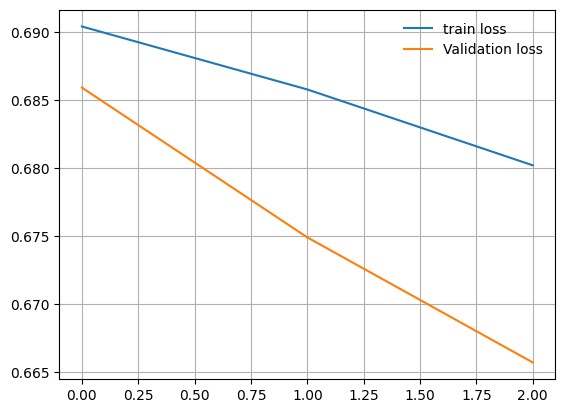

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

train_loss = [history['train_loss'] for history in train_helper.history]
val_loss = [history['val_loss'] for history in train_helper.history]

plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='Validation loss')
plt.grid()
plt.legend(frameon=False)

##### Accuracy

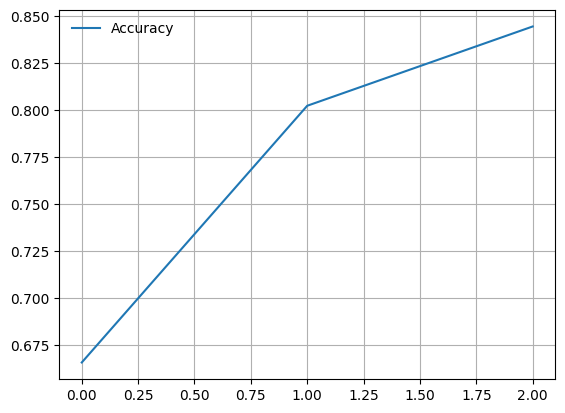

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

val_acc = [history['val_acc'] for history in train_helper.history]
plt.plot(val_acc, label='Accuracy')
plt.grid()
plt.legend(frameon=False)

## 5. Analysis

##### Confusion Matrix

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

#모델을 평가 모드로 전환
model.eval()

y_pred = []
y_true = []
for batch in tqdm(test_dl):
    inputs, targets = batch
    outputs = model(inputs)
    y_pred.extend(torch.max(outputs, dim=1)[1].cpu().numpy())
    y_true.extend(torch.max(targets, dim=1)[1].cpu().numpy())

performance = metrics.classification_report(y_true, y_pred, digits=3)
confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

classes = test_ds.classes
disp = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = list(range(len(classes))))
print(f"Classes : {classes}")
print(f"Performance \n{performance}")

disp.plot()
fig = disp.ax_.get_figure()
fig.set_figwidth(len(classes))
fig.set_figheight(len(classes))
plt.savefig("confusion_matrix.jpg")
plt.show()

#### Load Trained Model

In [ ]:
import torch

model=MobileViT()
model.load_state_dict(torch.load("./ckpt/best_ep_5_0.83675.pt", map_location='cpu'))

In [ ]:
# Recovery of normalized image dataset for visualization
normalize_inverted = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#### False Positive Cases

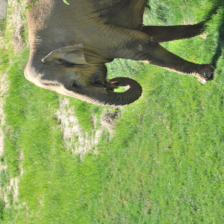

Prediction   : African (0.5037)
Ground Truth : Asian


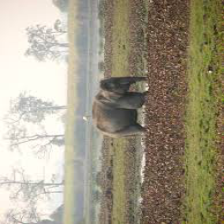

Prediction   : African (0.5103)
Ground Truth : Asian


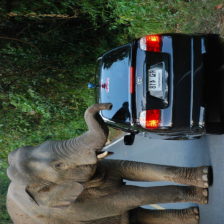

Prediction   : African (0.5113)
Ground Truth : Asian


In [ ]:
from IPython.display import display
from PIL import Image
FP = 3
for data in test_dl:
    if FP==0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()

    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if FP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p!=g:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            FP -= 1


#### True Positive Cases (Low confidence, Edge case)

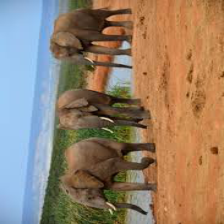

Prediction   : African (0.5185)
Ground Truth : African


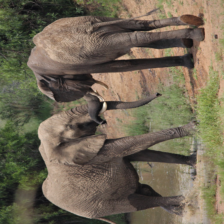

Prediction   : African (0.5347)
Ground Truth : African


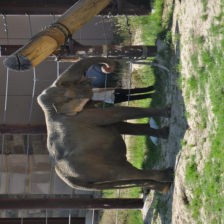

Prediction   : Asian (0.5323)
Ground Truth : Asian


In [ ]:
TP = 3
for data in test_dl:
    if TP <= 0:
        break
    img_batch, label_batch = data
    results = model(img_batch)
    confs, preds = torch.max(results, dim=1)
    _, gts = torch.max(label_batch, dim=1)
    preds = preds.numpy()
    confs = confs.detach().numpy()
    gts = gts.numpy()

    for img, p, conf, g in zip(img_batch, preds, confs, gts):
        if TP <= 0:
            break
        x = normalize_inverted(img).numpy()
        x = (x * 255).astype(np.uint8).T
        x = Image.fromarray(x)
        if p==g and conf < 0.55:
            display(x)
            print(f"Prediction   : {test_ds.classes[p]} ({conf:0.4f})")
            print(f"Ground Truth : {test_ds.classes[g]}")
            TP -= 1